# Prepare data for LM

In [ ]:
!conda install fastai

In [14]:
import pandas as pd 
from pathlib import Path
from fastai import *
from fastai.text import *
#import neptune

In [12]:
from fastai import *

In [4]:
# data
path = Path('/home/jupyter/toxic')
data_path = path/'data'
big_data_csv = 'wiki_langauge_model_data.csv'
fine_tune_data_csv = 'combined_langauge_model_data.csv'

# results
exp_nb = 2
wiki_vocab = 'wiki_vocab.pkl'

pretrained_data_lm = 'language_{}_data_wiki'
pretrained_lm_wiki_file = 'language_pretrained_{}_10ep_wiki'

pretrained_lm_fit_head_file = 'toxic_tuned_head_lm_model_{}'
pretrained_lm_final_file = 'toxic_final_lm_model_{}'
final_enc_lm_result_file = 'toxic_final_enc_lm_{}'
vocab_fit_lm = 'fine_tuned_{}_toxic_vocab_lm10ep_extended.pkl'

In [15]:
dir()

['In',
 'Out',
 'Path',
 '_',
 '_10',
 '_13',
 '_6',
 '_8',
 '__',
 '___',
 '__builtin__',
 '__builtins__',
 '__doc__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_dh',
 '_i',
 '_i1',
 '_i10',
 '_i11',
 '_i12',
 '_i13',
 '_i14',
 '_i15',
 '_i2',
 '_i3',
 '_i4',
 '_i5',
 '_i6',
 '_i7',
 '_i8',
 '_i9',
 '_ih',
 '_ii',
 '_iii',
 '_oh',
 'big_data_csv',
 'data_path',
 'exit',
 'exp_nb',
 'final_enc_lm_result_file',
 'fine_tune_data_csv',
 'get_ipython',
 'neptune',
 'path',
 'pd',
 'pretrained_data_lm',
 'pretrained_lm_final_file',
 'pretrained_lm_fit_head_file',
 'pretrained_lm_wiki_file',
 'quit',
 'text',
 'vocab_fit_lm',
 'wiki_vocab',
 'x_col_name']

In [5]:
x_col_name = 'comment_text'

architecture = Transformer

# main model
m_bs= 192
m_epochs = 10
m_layer1_lr = 4e-2
m_moms = (0.8,0.7)
DROP_MULT = 0.3

# fine tune
ft_bs = 192
ft1_epochs = 1
ft2_epochs = 10
layer1_lr = 1e-2
layer2_lr = 1e-3
momentum = (0.8,0.7)
FT_DROP_MULT = 0.3

SEED = 777

NameError: name 'Transformer' is not defined

In [4]:
# neptune.init(api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5tbCIsImFwaV9rZXkiOiJlNjA0OGZlMC0yODI5LTQ4ZDgtYjYyNi02NmUzZmI0MDNjNzYifQ==',
#              project_qualified_name='lachonman/toxic-bias')

# nep_exp = neptune.create_experiment(name='Language_Model_{}_FastAI'.format(exp_nb),
#                           description=
#                           'Language Model trained on train+test and old toxic text corpora.',
#                           params={'lr_layer1': layer1_lr,
#                                   'lr_layer2': layer2_lr,
#                                   'epochs_count': epochs,
#                                   'dropout': DROP_MULT,
#                                   'freeze_layer_idx': freeze_layer_idx,
#                                   'architecture': arch.__name__,
#                                  })
# nep_exp.append_tag('Wiki103')
# nep_exp.append_tag('toxic_train+test+old')
# nep_exp.append_tag(arch.__name__)
# nep_exp.append_tag('pretrained extended LangModel')

# Language Model

## Main train

### Create DataBunch for Language Model

In [5]:
data_lm = (TextList.from_csv(data_path, 'wikitext-2/train.csv')#'wikitext-103/train.csv')
                .random_split_by_pct(0.1)
                .label_for_lm()
                .databunch(bs=ft_bs))

In [6]:
data_lm.save(pretrained_data_lm)

In [7]:
#data_lm = load_data(path/pretrained_data_lm, bs=bs)

In [8]:
data_lm.show_batch()

### Train & Save

In [9]:
learn = language_model_learner(data_lm, architecture, drop_mult=DROP_MULT)

In [10]:
learn.model = torch.nn.DataParallel(learn.model)

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot(skip_end=15)

In [ ]:
learn.fit_one_cycle(m_epochs, m_layer1_lr, moms=m_moms)

In [ ]:
learn.save(pretrained_lm_file)

In [ ]:
with open(wiki_vocab, 'wb') as f:
pickle.dump(data_lm.vocab, f)

In [ ]:
learn.load(pretrained_lm_file);

In [ ]:
TEXT = "You fucking white trash"
N_WORDS = 20
N_SENTENCES = 3

In [ ]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.25) for _ in range(N_SENTENCES)))

In [ ]:
import pickle
with open(vocab_fit_lm, 'wb') as f:
    pickle.dump(data_lm.vocab, f)

## Fine Truning

In [ ]:
data_lm_fine_tune = (TextList.from_csv(path, fine_tune_data_csv, cols='comment_text')
                .split_by_rand_pct(0.1)
                .label_for_lm()
                .databunch(bs=ft_bs))

In [ ]:
learn2 = language_model_learner(data_lm, architecture, pretrained=False, drop_mult=FT_DROP_MULT)

In [ ]:
learn2.load_pretrained(wgts_fname=pretrained_lm_file, itos_fname=wiki_vocab)

In [ ]:
#learn.data.train_dl = data_lm_fine_tune

In [ ]:
#learn.load_encoder()

In [ ]:
learn.model = torch.nn.DataParallel(learn.model)

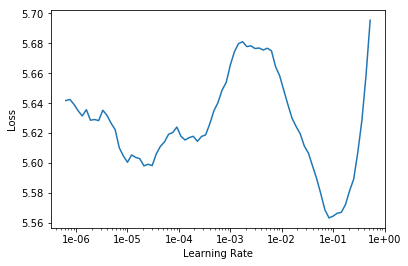

In [153]:
learn.recorder.plot(skip_end=15)

In [154]:
learn.fit_one_cycle(ft1_epochs, layer1_lr, moms=momentum)

In [155]:
learn.save(pretrained_lm_fit_head_file)

In [24]:
learn.load(pretrained_lm_fit_head_file);

In [25]:
learn.unfreeze()

In [1]:
learn.fit_one_cycle(ft2_epochs, layer2_lr, moms=momentum);

In [35]:
learn.save(pretrained_lm_final_file)

In [2]:
learn.load(pretrained_lm_final_file);

In [34]:
learn.save_encoder(final_enc_lm_result_file)

In [37]:
TEXT = "You fucking white trash"
N_WORDS = 20
N_SENTENCES = 3

In [39]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.25) for _ in range(N_SENTENCES)))

You fucking jew - hating Jews are the ones who are the problem . You are the problem . xxbos
You fucking jew . xxbos The American Dream is a Republican Party . It 's a
You fucking jew 's are a bunch of idiots . xxbos The Globe and Mail is a joke .


In [ ]:
import pickle
with open(vocab_fit_lm, 'wb') as f:
    pickle.dump(data_lm.vocab, f)